# Task 2: MITBIH: Shallow Neural Network with Short-Time Fourier Transform on Data

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import itertools
#import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import optimizers, losses, activations, models
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, SimpleRNN, Input, LSTM, Layer, Flatten
from keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.signal import stft
from matplotlib import pyplot as plt


In [ ]:
#gpu setup when using Tensorflow to address memory expansion/growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Read in data and split into train and test sets.

In [3]:
#read in data and split, from baseline
df_train = pd.read_csv("../01-Data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("../01-Data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)


Define the function to get the model.

The model gets the input and then the short-time fourier transform is applied to the input. This can be seen as a kind of feature engineering step. The input given is the raw signal (no normalization has been done on the data). 

The network of the model is very shallow, with two separate hidden layers which handle the real and imaginary parts of the fourier transform result,and one output layer combining the outputs of the two hidden layers. 

In [4]:
def get_model(fl, fs, reg, units):
    nclass = 1
    inp = Input(shape=(187,))
    reg = tf.keras.regularizers.l1(l1=reg)
    coeff1 = stft(
            inp, 
            frame_length= fl,
            frame_step=fs, 
            pad_end=True
            )

    dense_1 = Dense(units, activation=activations.relu, kernel_regularizer=reg, bias_regularizer=reg, name="dense_1")(tf.math.real(coeff1))
    #dense_11 = Dense(5, activation=activations.relu, name="dense_11")(dense_1)
    dense_2 = Dense(units, activation=activations.relu, kernel_regularizer=reg, bias_regularizer=reg, name="dense_2")(tf.math.imag(coeff1))
    #dense_21 = Dense(5, activation=activations.relu, name="dense_21")(dense_2)
    flatten = Flatten()(tf.concat([dense_1, dense_2], 1))
    dense_3 = Dense(nclass, activation=activations.softmax, name="dense_3_ptbdb")(flatten)

    model = models.Model(inputs=inp, outputs=dense_3)
    opt = optimizers.Adadelta(1)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model


Use the same optimal values found as for ptbdb dataset:

Best value for frame_length: 33

Best value for regularizer: 0

Best value for frame_step: 6

Best value for dense units: 55

Train the model with the train data set.

In [5]:
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)

m = get_model(33, 6, 0, 55)
m.fit(X, Y, epochs=200, verbose=2, validation_split=0.1, shuffle=True, callbacks=[early])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187)]        0           []                               
                                                                                                  
 tf.signal.stft (TFOpLambda)    (None, 32, 33)       0           ['input_1[0][0]']                
                                                                                                  
 tf.math.real (TFOpLambda)      (None, 32, 33)       0           ['tf.signal.stft[0][0]']         
                                                                                                  
 tf.math.imag (TFOpLambda)      (None, 32, 33)       0           ['tf.signal.stft[0][0]']         
                                                                                              

2022-03-26 18:59:57.092916: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2463/2463 - 5s - loss: nan - acc: 0.8269 - val_loss: nan - val_acc: 0.8318 - 5s/epoch - 2ms/step
Epoch 2/200
2463/2463 - 4s - loss: nan - acc: 0.8273 - val_loss: nan - val_acc: 0.8318 - 4s/epoch - 2ms/step
Epoch 3/200
2463/2463 - 4s - loss: nan - acc: 0.8273 - val_loss: nan - val_acc: 0.8318 - 4s/epoch - 2ms/step
Epoch 4/200
2463/2463 - 4s - loss: nan - acc: 0.8273 - val_loss: nan - val_acc: 0.8318 - 4s/epoch - 2ms/step


Do prediction on the test set.  

Print out f1 and accuracy score.

Define helper function to plot confusion matrix.

Test f1 score : 0.18113471632091976 
Test accuracy score : 0.8276082587246483 
Confusion matrix: 


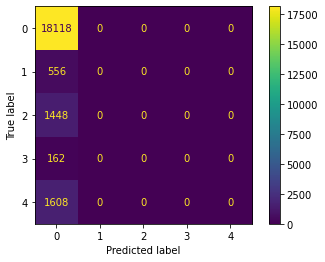

In [13]:
predicted_labels = m.predict(X_test)
predicted_labels = tf.math.argmax(predicted_labels, axis=1)
#prediction scores

f1 = f1_score(Y_test, predicted_labels, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, predicted_labels)

print("Test accuracy score : %s "% acc)

print("Confusion matrix: ")

cm =  confusion_matrix(Y_test, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
